In [1]:
import sys
sys.path.insert(0, '../')

import pandas as pd
from sklearn import metrics
from keras.wrappers.scikit_learn import KerasClassifier
from classification_plots import plot_confusion_matrix
import matplotlib.pyplot as plt
import os
from collections import Counter
from sklearn.multiclass import OneVsRestClassifier

Using TensorFlow backend.


In [2]:
%load_ext memory_profiler
%load_ext line_profiler

In [3]:
# Able to specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="0"

orig_SR = 44100
orig_blocksize = int(orig_SR * 5)
orig_overlap = 0 #int(orig_SR/4)

SR = 16000
blocksize = int(SR * 5)
overlap = 0 #int(SR/4)

In [4]:
import warnings
warnings.filterwarnings('ignore')

## Setup

In [5]:
audio_dir = '../../ESC-50/audio/'
path_to_db='../../ESC-50/'

# Load Dataset
Here we load the csv that describes each file in the dataset. We add a high level category that is defined in the ESC-50 documentation. This we realize is anthetical to true training, it is a stopgap for when we use NLP to classify tags into these categories.

In [6]:
dataset = pd.read_csv(path_to_db + 'meta/esc50.csv')
classes = [None] * 50

In [7]:
h_classes = ['Human & Animal', 'Interacting Materials']
mapping = {'dog': 0,'rooster': 0,'pig': 0,'cow': 0,'frog': 0,'cat': 0,'hen': 0,
            'insects': 0,'sheep': 0,'crow': 0,'rain': 1,'sea_waves': 1,'crackling_fire': 1,
            'crickets': 0,'chirping_birds': 0,'water_drops': 1,'wind': 1,'pouring_water': 1,
            'toilet_flush': 1,'thunderstorm': 1,'crying_baby': 0,'sneezing': 0,'clapping': 0,
            'breathing': 0,'coughing': 0,'footsteps': 1,'laughing': 0,'brushing_teeth': 1,
            'snoring': 0,'drinking_sipping': 1,'door_wood_knock': 1,'mouse_click': 1,
            'keyboard_typing': 1,'door_wood_creaks': 1,'can_opening': 1,'washing_machine': 1,
            'vacuum_cleaner': 1,'clock_alarm': 1,'clock_tick': 1,'glass_breaking':1,'helicopter': 1,
            'chainsaw': 1,'siren': 1,'car_horn': 1,'engine': 1,'train': 1,'church_bells': 1,
            'airplane': 1,'fireworks': 1,'hand_saw': 1,
            }

In [8]:
dataset['h_target'] = None
for index, row in dataset.iterrows():
    target = row['target']
    classes[target] = row['category']
    dataset.loc[index, 'h_target'] = mapping[row['category']]

In [9]:
dataset.head()

,filename,fold,target,category,esc10,src_file,take,h_target
0,1-100032-A-0.wav,1,0,dog,True,100032,A,0
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A,0
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A,1
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B,1
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A,1


## Loading

In [10]:
%%file load_blockwise.py

audio_dir = '../../ESC-50/audio/'
path_to_db='../../ESC-50/'

orig_SR = 44100
orig_blocksize = int(orig_SR * 5)
orig_overlap = 0 #int(orig_SR/4)

SR = 16000
blocksize = int(SR * 5)
overlap = 0 #int(SR/4)

import time
import librosa
import numpy as np
import soundfile as sf

def load_audio_blockwise(data, blocksize=1024, overlap=512, debug=False):
    start_time = time.time()
    items = []
    target = []
    h_target = []
    for i, sample in data.iterrows():
        if debug:
            print("File Processing", end="", flush=True)
        blockgen = sf.blocks(audio_dir + sample['filename'], 
                             blocksize=blocksize, 
                             overlap=overlap, 
                             always_2d=True,
                             fill_value=0.0)
        sr = sf.info(audio_dir + sample['filename']).samplerate
        for bl in blockgen:
            if not np.any(bl):
                continue
            if debug:
                print(".", end="", flush=True)
            y = bl.transpose()
            y = librosa.resample(y, sr, SR)
            y = y[:int(blocksize)]
            y = y[np.newaxis, :]
            items.append(y)
            h_target.append(sample.h_target)
            target.append(sample.target)
        if debug:
            print("Done")
    if debug:
        print("\tProcessing Time: " + str(time.time() - start_time))
    return np.vstack(items), np.array(h_target), np.array(target)

def load_file_blockwise(filename, blocksize=1024, overlap=512, debug=False):
    items = []
    if debug:
        print("File Processing", end="", flush=True)
    blockgen = sf.blocks(audio_dir + filename, 
                         blocksize=blocksize, 
                         overlap=overlap, 
                         always_2d=True,
                         fill_value=0.0)
    sr = sf.info(audio_dir + filename).samplerate
    for bl in blockgen:
        if not np.any(bl):
            continue
        if debug:
            print(".", end="", flush=True)
        y = bl.transpose()
        y = librosa.resample(y, sr, SR)
        y = y[:int(blocksize)]
        y = y[np.newaxis, :]
        items.append(y)
        
    if debug:
        print("Done")

    return items

Overwriting load_blockwise.py


In [11]:
%%time
from load_blockwise import load_audio_blockwise

%memit train_X, train_y, train_yy = load_audio_blockwise(dataset[dataset.fold != 1], orig_blocksize, orig_overlap)

peak memory: 2507.89 MiB, increment: 2207.08 MiB
CPU times: user 4min 9s, sys: 1.78 s, total: 4min 11s
Wall time: 4min 11s


In [12]:
%%time
%memit test_X, test_y, test_yy = load_audio_blockwise(dataset[dataset.fold == 1], orig_blocksize, orig_overlap)

peak memory: 1805.76 MiB, increment: 511.07 MiB
CPU times: user 1min 2s, sys: 692 ms, total: 1min 3s
Wall time: 1min 3s


## Estimator

In [13]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Convolution2D, MaxPooling2D, Flatten, InputLayer
import keras.metrics as kmet
from kapre.time_frequency import Melspectrogram, Spectrogram
from kapre.utils import Normalization2D
from kapre.augmentation import AdditiveNoise

ensemble_num = 10
num_hidden_neurons = 10
dropout = 0.25

epochs = 5
batch = 128

def gpu_mfcc_shallow_net():
    # Create Model
    # Create Model
    model = Sequential()
    model.add(Melspectrogram(
        sr=SR,
        n_mels=128,
        power_melgram=1.0,
        input_shape=(1, blocksize),
        trainable_fb=False,
        fmin = 800,
        fmax = 8000
    ))
    model.add(Convolution2D(32, 9, 9, name='conv1', activation='relu'))
    model.add(MaxPooling2D((25, 17)))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(2, kernel_initializer='normal', activation='softmax'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy', kmet.mae])
    
    model.summary()

    
    return model

In [14]:
%%time

clas = OneVsRestClassifier(KerasClassifier(build_fn=gpu_mfcc_shallow_net,
                       epochs=epochs, 
                       batch_size=batch, 
                       validation_split=0.15))

%memit history = clas.fit(train_X, train_yy)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
melspectrogram_1 (Melspectro (None, 128, 313, 1)       296064    
_________________________________________________________________
conv1 (Conv2D)               (None, 120, 305, 32)      2624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 17, 32)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2176)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                69664     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
__________

1360/1360 [==============================] - 74s 54ms/step - loss: 0.2836 - acc: 0.9765 - mean_absolute_error: 0.0706 - val_loss: 0.0952 - val_acc: 1.0000 - val_mean_absolute_error: 0.0868
Epoch 5/5
1360/1360 [==============================] - 73s 53ms/step - loss: 0.2448 - acc: 0.9765 - mean_absolute_error: 0.1341 - val_loss: 0.1504 - val_acc: 1.0000 - val_mean_absolute_error: 0.1367
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
melspectrogram_4 (Melspectro (None, 128, 313, 1)       296064    
_________________________________________________________________
conv1 (Conv2D)               (None, 120, 305, 32)      2624      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 4, 17, 32)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 2176)              0         
__________________

1360/1360 [==============================] - 73s 53ms/step - loss: 0.2996 - acc: 0.9794 - mean_absolute_error: 0.1783 - val_loss: 0.2071 - val_acc: 0.9833 - val_mean_absolute_error: 0.0858
Epoch 3/5
1360/1360 [==============================] - 72s 53ms/step - loss: 0.2259 - acc: 0.9794 - mean_absolute_error: 0.0627 - val_loss: 0.1790 - val_acc: 0.9833 - val_mean_absolute_error: 0.0471
Epoch 4/5
1360/1360 [==============================] - 73s 54ms/step - loss: 0.2016 - acc: 0.9794 - mean_absolute_error: 0.0494 - val_loss: 0.1240 - val_acc: 0.9833 - val_mean_absolute_error: 0.0503
Epoch 5/5
1360/1360 [==============================] - 73s 53ms/step - loss: 0.1950 - acc: 0.9794 - mean_absolute_error: 0.0723 - val_loss: 0.1101 - val_acc: 0.9833 - val_mean_absolute_error: 0.0821
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
melspectrogram_7 (Melspectro (None, 128, 313, 1)       296064    
________________

Train on 1360 samples, validate on 240 samples
Epoch 1/5
1360/1360 [==============================] - 74s 55ms/step - loss: 0.5497 - acc: 0.9257 - mean_absolute_error: 0.4100 - val_loss: 0.2969 - val_acc: 0.9958 - val_mean_absolute_error: 0.2361
Epoch 2/5
1360/1360 [==============================] - 73s 54ms/step - loss: 0.2654 - acc: 0.9772 - mean_absolute_error: 0.1373 - val_loss: 0.1109 - val_acc: 0.9958 - val_mean_absolute_error: 0.0488
Epoch 3/5
1360/1360 [==============================] - 73s 53ms/step - loss: 0.2688 - acc: 0.9772 - mean_absolute_error: 0.0497 - val_loss: 0.0926 - val_acc: 0.9958 - val_mean_absolute_error: 0.0283
Epoch 4/5
1360/1360 [==============================] - 73s 53ms/step - loss: 0.2310 - acc: 0.9772 - mean_absolute_error: 0.0586 - val_loss: 0.0946 - val_acc: 0.9958 - val_mean_absolute_error: 0.0622
Epoch 5/5
1360/1360 [==============================] - 72s 53ms/step - loss: 0.2116 - acc: 0.9772 - mean_absolute_error: 0.1058 - val_loss: 0.1177 - val_acc:

Train on 1360 samples, validate on 240 samples
Epoch 1/5
1360/1360 [==============================] - 75s 55ms/step - loss: 0.6772 - acc: 0.8162 - mean_absolute_error: 0.4916 - val_loss: 0.6212 - val_acc: 0.9750 - val_mean_absolute_error: 0.4613
Epoch 2/5
1360/1360 [==============================] - 73s 54ms/step - loss: 0.4532 - acc: 0.9809 - mean_absolute_error: 0.3462 - val_loss: 0.3190 - val_acc: 0.9750 - val_mean_absolute_error: 0.2044
Epoch 3/5
1360/1360 [==============================] - 72s 53ms/step - loss: 0.2779 - acc: 0.9809 - mean_absolute_error: 0.1131 - val_loss: 0.3446 - val_acc: 0.9750 - val_mean_absolute_error: 0.0869
Epoch 4/5
1360/1360 [==============================] - 72s 53ms/step - loss: 0.2465 - acc: 0.9809 - mean_absolute_error: 0.0825 - val_loss: 0.2522 - val_acc: 0.9750 - val_mean_absolute_error: 0.1119
Epoch 5/5
1360/1360 [==============================] - 72s 53ms/step - loss: 0.1880 - acc: 0.9809 - mean_absolute_error: 0.0993 - val_loss: 0.1997 - val_acc:

Train on 1360 samples, validate on 240 samples
Epoch 1/5
1360/1360 [==============================] - 76s 56ms/step - loss: 0.6122 - acc: 0.8625 - mean_absolute_error: 0.4523 - val_loss: 0.4035 - val_acc: 0.9667 - val_mean_absolute_error: 0.3151
Epoch 2/5
1360/1360 [==============================] - 72s 53ms/step - loss: 0.2780 - acc: 0.9809 - mean_absolute_error: 0.1903 - val_loss: 0.1879 - val_acc: 0.9667 - val_mean_absolute_error: 0.0983
Epoch 3/5
1360/1360 [==============================] - 74s 55ms/step - loss: 0.1744 - acc: 0.9824 - mean_absolute_error: 0.0601 - val_loss: 0.1995 - val_acc: 0.9667 - val_mean_absolute_error: 0.0571
Epoch 4/5
1360/1360 [==============================] - 72s 53ms/step - loss: 0.1381 - acc: 0.9824 - mean_absolute_error: 0.0461 - val_loss: 0.1566 - val_acc: 0.9667 - val_mean_absolute_error: 0.0698
Epoch 5/5
1360/1360 [==============================] - 73s 54ms/step - loss: 0.1204 - acc: 0.9824 - mean_absolute_error: 0.0531 - val_loss: 0.1395 - val_acc:

Train on 1360 samples, validate on 240 samples
Epoch 1/5
1360/1360 [==============================] - 76s 56ms/step - loss: 0.4803 - acc: 0.9743 - mean_absolute_error: 0.3619 - val_loss: 0.3117 - val_acc: 0.9667 - val_mean_absolute_error: 0.1927
Epoch 2/5
1360/1360 [==============================] - 73s 54ms/step - loss: 0.1495 - acc: 0.9824 - mean_absolute_error: 0.0886 - val_loss: 0.3534 - val_acc: 0.9667 - val_mean_absolute_error: 0.0603
Epoch 3/5
1360/1360 [==============================] - 73s 53ms/step - loss: 0.1439 - acc: 0.9824 - mean_absolute_error: 0.0359 - val_loss: 0.3571 - val_acc: 0.9667 - val_mean_absolute_error: 0.0522
Epoch 4/5
1360/1360 [==============================] - 73s 54ms/step - loss: 0.1398 - acc: 0.9824 - mean_absolute_error: 0.0410 - val_loss: 0.3241 - val_acc: 0.9667 - val_mean_absolute_error: 0.0768
Epoch 5/5
1360/1360 [==============================] - 72s 53ms/step - loss: 0.1159 - acc: 0.9824 - mean_absolute_error: 0.0590 - val_loss: 0.2794 - val_acc:

Train on 1360 samples, validate on 240 samples
Epoch 1/5
1360/1360 [==============================] - 75s 55ms/step - loss: 0.6718 - acc: 0.8338 - mean_absolute_error: 0.4886 - val_loss: 0.6045 - val_acc: 1.0000 - val_mean_absolute_error: 0.4519
Epoch 2/5
1360/1360 [==============================] - 72s 53ms/step - loss: 0.4738 - acc: 0.9757 - mean_absolute_error: 0.3514 - val_loss: 0.2515 - val_acc: 1.0000 - val_mean_absolute_error: 0.2071
Epoch 3/5
1360/1360 [==============================] - 73s 54ms/step - loss: 0.3090 - acc: 0.9765 - mean_absolute_error: 0.1471 - val_loss: 0.0933 - val_acc: 1.0000 - val_mean_absolute_error: 0.0831
Epoch 4/5
1360/1360 [==============================] - 74s 54ms/step - loss: 0.3083 - acc: 0.9765 - mean_absolute_error: 0.1028 - val_loss: 0.1069 - val_acc: 1.0000 - val_mean_absolute_error: 0.0957
Epoch 5/5
1360/1360 [==============================] - 72s 53ms/step - loss: 0.2822 - acc: 0.9765 - mean_absolute_error: 0.1319 - val_loss: 0.1228 - val_acc:

Train on 1360 samples, validate on 240 samples
Epoch 1/5
1360/1360 [==============================] - 76s 56ms/step - loss: 0.4778 - acc: 0.9772 - mean_absolute_error: 0.3608 - val_loss: 0.2285 - val_acc: 0.9667 - val_mean_absolute_error: 0.1710
Epoch 2/5
1360/1360 [==============================] - 75s 55ms/step - loss: 0.1680 - acc: 0.9824 - mean_absolute_error: 0.0749 - val_loss: 0.2163 - val_acc: 0.9667 - val_mean_absolute_error: 0.0524
Epoch 3/5
1360/1360 [==============================] - 74s 54ms/step - loss: 0.1603 - acc: 0.9824 - mean_absolute_error: 0.0287 - val_loss: 0.2316 - val_acc: 0.9667 - val_mean_absolute_error: 0.0438
Epoch 4/5
1360/1360 [==============================] - 71s 52ms/step - loss: 0.1542 - acc: 0.9824 - mean_absolute_error: 0.0343 - val_loss: 0.1755 - val_acc: 0.9667 - val_mean_absolute_error: 0.0604
Epoch 5/5
1360/1360 [==============================] - 75s 55ms/step - loss: 0.1317 - acc: 0.9824 - mean_absolute_error: 0.0472 - val_loss: 0.1538 - val_acc:

Train on 1360 samples, validate on 240 samples
Epoch 1/5
1360/1360 [==============================] - 78s 58ms/step - loss: 0.5283 - acc: 0.9169 - mean_absolute_error: 0.3838 - val_loss: 0.3692 - val_acc: 0.9708 - val_mean_absolute_error: 0.2145
Epoch 2/5
1360/1360 [==============================] - 72s 53ms/step - loss: 0.2588 - acc: 0.9816 - mean_absolute_error: 0.1120 - val_loss: 0.3680 - val_acc: 0.9708 - val_mean_absolute_error: 0.0767
Epoch 3/5
1360/1360 [==============================] - 75s 55ms/step - loss: 0.2582 - acc: 0.9816 - mean_absolute_error: 0.0460 - val_loss: 0.3832 - val_acc: 0.9708 - val_mean_absolute_error: 0.0494
Epoch 4/5
1360/1360 [==============================] - 74s 55ms/step - loss: 0.2408 - acc: 0.9816 - mean_absolute_error: 0.0483 - val_loss: 0.3035 - val_acc: 0.9708 - val_mean_absolute_error: 0.0842
Epoch 5/5
1360/1360 [==============================] - 72s 53ms/step - loss: 0.1740 - acc: 0.9816 - mean_absolute_error: 0.0806 - val_loss: 0.2276 - val_acc:

Train on 1360 samples, validate on 240 samples
Epoch 1/5
1360/1360 [==============================] - 79s 58ms/step - loss: 0.3535 - acc: 0.9794 - mean_absolute_error: 0.2731 - val_loss: 0.1492 - val_acc: 0.9667 - val_mean_absolute_error: 0.1006
Epoch 2/5
1360/1360 [==============================] - 74s 54ms/step - loss: 0.1209 - acc: 0.9824 - mean_absolute_error: 0.0455 - val_loss: 0.1987 - val_acc: 0.9667 - val_mean_absolute_error: 0.0404
Epoch 3/5
1360/1360 [==============================] - 73s 54ms/step - loss: 0.1392 - acc: 0.9824 - mean_absolute_error: 0.0249 - val_loss: 0.1910 - val_acc: 0.9667 - val_mean_absolute_error: 0.0412
Epoch 4/5
1360/1360 [==============================] - 74s 55ms/step - loss: 0.1290 - acc: 0.9824 - mean_absolute_error: 0.0285 - val_loss: 0.1589 - val_acc: 0.9667 - val_mean_absolute_error: 0.0483
Epoch 5/5
1360/1360 [==============================] - 73s 54ms/step - loss: 0.1229 - acc: 0.9824 - mean_absolute_error: 0.0360 - val_loss: 0.1395 - val_acc:

Train on 1360 samples, validate on 240 samples
Epoch 1/5
1360/1360 [==============================] - 79s 58ms/step - loss: 0.5974 - acc: 0.9022 - mean_absolute_error: 0.4433 - val_loss: 0.4085 - val_acc: 0.9667 - val_mean_absolute_error: 0.3169
Epoch 2/5
1360/1360 [==============================] - 72s 53ms/step - loss: 0.2184 - acc: 0.9824 - mean_absolute_error: 0.1634 - val_loss: 0.2404 - val_acc: 0.9667 - val_mean_absolute_error: 0.0802
Epoch 3/5
1360/1360 [==============================] - 71s 52ms/step - loss: 0.1010 - acc: 0.9824 - mean_absolute_error: 0.0392 - val_loss: 0.3016 - val_acc: 0.9667 - val_mean_absolute_error: 0.0447
Epoch 4/5
1360/1360 [==============================] - 72s 53ms/step - loss: 0.1205 - acc: 0.9824 - mean_absolute_error: 0.0290 - val_loss: 0.2829 - val_acc: 0.9667 - val_mean_absolute_error: 0.0484
Epoch 5/5
1360/1360 [==============================] - 72s 53ms/step - loss: 0.1064 - acc: 0.9824 - mean_absolute_error: 0.0409 - val_loss: 0.2202 - val_acc:

Train on 1360 samples, validate on 240 samples
Epoch 1/5
1360/1360 [==============================] - 79s 58ms/step - loss: 0.4171 - acc: 0.9750 - mean_absolute_error: 0.3174 - val_loss: 0.2202 - val_acc: 0.9750 - val_mean_absolute_error: 0.1414
Epoch 2/5
1360/1360 [==============================] - 72s 53ms/step - loss: 0.1721 - acc: 0.9809 - mean_absolute_error: 0.0677 - val_loss: 0.2553 - val_acc: 0.9750 - val_mean_absolute_error: 0.0479
Epoch 3/5
1360/1360 [==============================] - 72s 53ms/step - loss: 0.1697 - acc: 0.9809 - mean_absolute_error: 0.0404 - val_loss: 0.1957 - val_acc: 0.9750 - val_mean_absolute_error: 0.0580
Epoch 4/5
1360/1360 [==============================] - 71s 52ms/step - loss: 0.1418 - acc: 0.9809 - mean_absolute_error: 0.0606 - val_loss: 0.1572 - val_acc: 0.9750 - val_mean_absolute_error: 0.0907
Epoch 5/5
1360/1360 [==============================] - 71s 53ms/step - loss: 0.1245 - acc: 0.9809 - mean_absolute_error: 0.0725 - val_loss: 0.1328 - val_acc:

Train on 1360 samples, validate on 240 samples
Epoch 1/5
1360/1360 [==============================] - 79s 58ms/step - loss: 0.6413 - acc: 0.8029 - mean_absolute_error: 0.4707 - val_loss: 0.4584 - val_acc: 0.9708 - val_mean_absolute_error: 0.3565
Epoch 2/5
1360/1360 [==============================] - 73s 53ms/step - loss: 0.2456 - acc: 0.9809 - mean_absolute_error: 0.1905 - val_loss: 0.1390 - val_acc: 0.9708 - val_mean_absolute_error: 0.0772
Epoch 3/5
1360/1360 [==============================] - 71s 52ms/step - loss: 0.1113 - acc: 0.9816 - mean_absolute_error: 0.0416 - val_loss: 0.1801 - val_acc: 0.9708 - val_mean_absolute_error: 0.0390
Epoch 4/5
1360/1360 [==============================] - 70s 52ms/step - loss: 0.1092 - acc: 0.9816 - mean_absolute_error: 0.0301 - val_loss: 0.1540 - val_acc: 0.9708 - val_mean_absolute_error: 0.0449
Epoch 5/5
1360/1360 [==============================] - 71s 52ms/step - loss: 0.1059 - acc: 0.9816 - mean_absolute_error: 0.0429 - val_loss: 0.1309 - val_acc:

Train on 1360 samples, validate on 240 samples
Epoch 1/5
1360/1360 [==============================] - 78s 57ms/step - loss: 0.5631 - acc: 0.9360 - mean_absolute_error: 0.4181 - val_loss: 0.3529 - val_acc: 0.9875 - val_mean_absolute_error: 0.2566
Epoch 2/5
1360/1360 [==============================] - 71s 52ms/step - loss: 0.3193 - acc: 0.9779 - mean_absolute_error: 0.1556 - val_loss: 0.2600 - val_acc: 0.9875 - val_mean_absolute_error: 0.1022
Epoch 3/5
1360/1360 [==============================] - 73s 54ms/step - loss: 0.2733 - acc: 0.9787 - mean_absolute_error: 0.0982 - val_loss: 0.2131 - val_acc: 0.9875 - val_mean_absolute_error: 0.1105
Epoch 4/5
1360/1360 [==============================] - 73s 53ms/step - loss: 0.2135 - acc: 0.9787 - mean_absolute_error: 0.1235 - val_loss: 0.1633 - val_acc: 0.9875 - val_mean_absolute_error: 0.1080
Epoch 5/5
1360/1360 [==============================] - 72s 53ms/step - loss: 0.1698 - acc: 0.9787 - mean_absolute_error: 0.0858 - val_loss: 0.0891 - val_acc:

Train on 1360 samples, validate on 240 samples
Epoch 1/5
1360/1360 [==============================] - 80s 59ms/step - loss: 0.5877 - acc: 0.8846 - mean_absolute_error: 0.4363 - val_loss: 0.3869 - val_acc: 0.9667 - val_mean_absolute_error: 0.2962
Epoch 2/5
1360/1360 [==============================] - 73s 53ms/step - loss: 0.2624 - acc: 0.9816 - mean_absolute_error: 0.1668 - val_loss: 0.2878 - val_acc: 0.9667 - val_mean_absolute_error: 0.1016
Epoch 3/5
1360/1360 [==============================] - 72s 53ms/step - loss: 0.1980 - acc: 0.9824 - mean_absolute_error: 0.0595 - val_loss: 0.3181 - val_acc: 0.9667 - val_mean_absolute_error: 0.0643
Epoch 4/5
1360/1360 [==============================] - 70s 52ms/step - loss: 0.1862 - acc: 0.9824 - mean_absolute_error: 0.0542 - val_loss: 0.2433 - val_acc: 0.9667 - val_mean_absolute_error: 0.0841
Epoch 5/5
1360/1360 [==============================] - 71s 52ms/step - loss: 0.1529 - acc: 0.9824 - mean_absolute_error: 0.0745 - val_loss: 0.1999 - val_acc:

Train on 1360 samples, validate on 240 samples
Epoch 1/5
1360/1360 [==============================] - 82s 61ms/step - loss: 0.5185 - acc: 0.9735 - mean_absolute_error: 0.3878 - val_loss: 0.3045 - val_acc: 0.9667 - val_mean_absolute_error: 0.2233
Epoch 2/5
1360/1360 [==============================] - 72s 53ms/step - loss: 0.2397 - acc: 0.9824 - mean_absolute_error: 0.1100 - val_loss: 0.2922 - val_acc: 0.9667 - val_mean_absolute_error: 0.0794
Epoch 3/5
1360/1360 [==============================] - 72s 53ms/step - loss: 0.1983 - acc: 0.9824 - mean_absolute_error: 0.0484 - val_loss: 0.2615 - val_acc: 0.9667 - val_mean_absolute_error: 0.0665
Epoch 4/5
1360/1360 [==============================] - 72s 53ms/step - loss: 0.1966 - acc: 0.9824 - mean_absolute_error: 0.0539 - val_loss: 0.1969 - val_acc: 0.9667 - val_mean_absolute_error: 0.0716
Epoch 5/5
1360/1360 [==============================] - 72s 53ms/step - loss: 0.1387 - acc: 0.9824 - mean_absolute_error: 0.0463 - val_loss: 0.1680 - val_acc:

In [16]:
help(clas)

Help on OneVsRestClassifier in module sklearn.multiclass object:

class OneVsRestClassifier(sklearn.base.BaseEstimator, sklearn.base.ClassifierMixin, sklearn.base.MetaEstimatorMixin)
 |  One-vs-the-rest (OvR) multiclass/multilabel strategy
 |  
 |  Also known as one-vs-all, this strategy consists in fitting one classifier
 |  per class. For each classifier, the class is fitted against all the other
 |  classes. In addition to its computational efficiency (only `n_classes`
 |  classifiers are needed), one advantage of this approach is its
 |  interpretability. Since each class is represented by one and one classifier
 |  only, it is possible to gain knowledge about the class by inspecting its
 |  corresponding classifier. This is the most commonly used strategy for
 |  multiclass classification and is a fair default choice.
 |  
 |  This strategy can also be used for multilabel learning, where a classifier
 |  is used to predict multiple labels for instance, by fitting on a 2-d matrix
 

In [18]:
print(clas.classes_)
print(clas.estimators_)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
[<keras.wrappers.scikit_learn.KerasClassifier object at 0x7fcf6d4a0908>, <keras.wrappers.scikit_learn.KerasClassifier object at 0x7fcf6d52aa90>, <keras.wrappers.scikit_learn.KerasClassifier object at 0x7fcf6c893588>, <keras.wrappers.scikit_learn.KerasClassifier object at 0x7fcf6bcb9748>, <keras.wrappers.scikit_learn.KerasClassifier object at 0x7fcf6ab95da0>, <keras.wrappers.scikit_learn.KerasClassifier object at 0x7fcf69bbc3c8>, <keras.wrappers.scikit_learn.KerasClassifier object at 0x7fcf6904d240>, <keras.wrappers.scikit_learn.KerasClassifier object at 0x7fcf68e054a8>, <keras.wrappers.scikit_learn.KerasClassifier object at 0x7fcf6824eb38>, <keras.wrappers.scikit_learn.KerasClassifier object at 0x7fcf596096a0>, <keras.wrappers.scikit_learn.KerasClassifier object at 0x7fce5c334f28>, <keras.wrappers.scikit_learn.KerasClassifier object a

In [20]:
for i in range(len(clas.classes_)):
    model_json = clas.estimators_[i].model.to_json()
    with open(classes[i] + "_model.json", "w") as json_file:
        json_file.write(model_json)
    clas.estimators_[i].model.save_weights(classes[i] + "_model.h5")
    print(classes[i] + " saved to disk.")

dog saved to disk.
rooster saved to disk.
pig saved to disk.
cow saved to disk.
frog saved to disk.
cat saved to disk.
hen saved to disk.
insects saved to disk.
sheep saved to disk.
crow saved to disk.
rain saved to disk.
sea_waves saved to disk.
crackling_fire saved to disk.
crickets saved to disk.
chirping_birds saved to disk.
water_drops saved to disk.
wind saved to disk.
pouring_water saved to disk.
toilet_flush saved to disk.
thunderstorm saved to disk.
crying_baby saved to disk.
sneezing saved to disk.
clapping saved to disk.
breathing saved to disk.
coughing saved to disk.
footsteps saved to disk.
laughing saved to disk.
brushing_teeth saved to disk.
snoring saved to disk.
drinking_sipping saved to disk.
door_wood_knock saved to disk.
mouse_click saved to disk.
keyboard_typing saved to disk.
door_wood_creaks saved to disk.
can_opening saved to disk.
washing_machine saved to disk.
vacuum_cleaner saved to disk.
clock_alarm saved to disk.
clock_tick saved to disk.
glass_breaking sa

0.0725
Confusion matrix, without normalization
[[0 0 6 ... 0 0 0]
 [0 5 2 ... 0 0 0]
 [0 0 7 ... 0 0 0]
 ...
 [0 0 4 ... 0 0 0]
 [0 0 2 ... 0 0 0]
 [0 0 6 ... 0 0 0]]


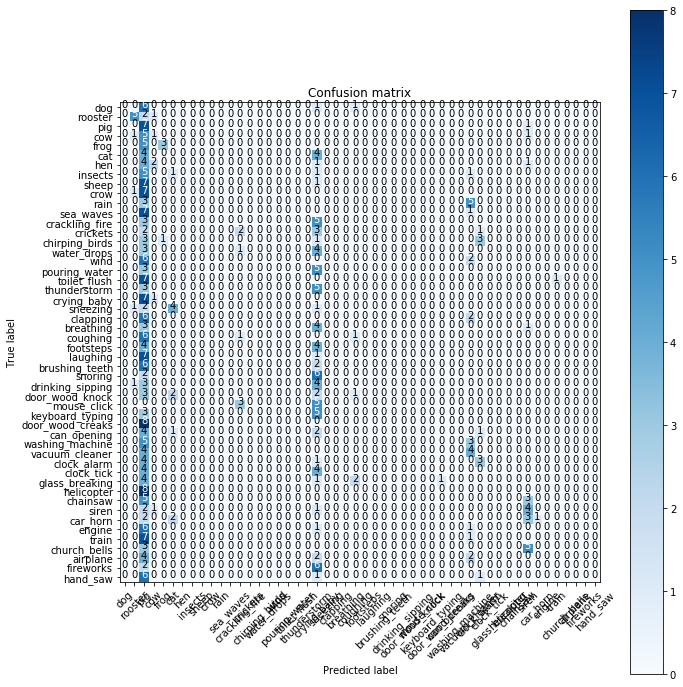

CPU times: user 1h 9min 38s, sys: 10min 15s, total: 1h 19min 53s
Wall time: 11min 51s


In [15]:
%%time

pred = clas.predict(test_X)
print(metrics.accuracy_score(test_yy, pred))
cm = metrics.confusion_matrix(test_yy, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes)
plt.show()

## Full Evaluation
We combine the classifiers to determine overall performance

In [ ]:
%%time

import time
from load_blockwise import load_file_blockwise

predictions = []
full_targets = []
start_time = time.time()
top_pred_probs = []
pred_probs = []

for data_iloc in range(0,2000):
    s_time = time.time()
    x_file = load_file_blockwise(dataset.iloc[data_iloc].filename,
                                 blocksize=orig_blocksize,
                                 overlap=orig_overlap)
    y_file = dataset.iloc[data_iloc].h_target
    yy_file = dataset.iloc[data_iloc].target
    
    pred = clas.predict(x_file)
    pred_probs.append(clas.predict_proba(x_file))
    b = Counter(pred)
    predictions.append(b.most_common(1)[0][0])
   
    full_targets.append(yy_file)
    print("\tFile Time: " + str(time.time() - s_time))


In [ ]:
print(metrics.accuracy_score(full_targets, predictions))
print(metrics.precision_score(full_targets, predictions, average='macro'))
cm = metrics.confusion_matrix(full_targets, predictions)
plt.figure(figsize=(20,20))
plot_confusion_matrix(cm, classes)
plt.show()

# Cross Validation

In [ ]:
clf = OneVsRestClassifier(KerasClassifier(build_fn=gpu_mfcc_shallow_net,
                       epochs=epochs, 
                       batch_size=batch, 
                       validation_split=0.15))

In [ ]:
%%time
from sklearn.model_selection import cross_validate

scores = cross_validate(clf, train_X, train_yy, cv=3, scoring=['accuracy', 'precision_macro', 'recall_macro'])

In [ ]:
clf.fit(train_X, train_yy)

In [ ]:
pd.DataFrame(scores)

In [ ]:
def heuristic(score_array):
    mu_t = np.mean(score_array)
    std_t = np.std(score_array)
    for i in range(0, len(score_array)):
        score_array[i] = (score_array[i] - mu_t)/std_t
    return score_array

In [ ]:
def query_dataset(query_term):
    h_l = mapping[query_term]
    l_l = classes.index(query_term)

    predictions = []
    test = df[df.fold == 1]

    for data_iloc in range(0,len(X_test)):
        x_file = X_test[X_test.index == data_iloc]
    
        y_file = y_test[data_iloc]
        
        y_file = dataset.iloc[data_iloc].h_target
        yy_file = dataset.iloc[data_iloc].target

        predictions.append({
            'file': dataset.iloc[data_iloc].filename,
            'ds_id': data_iloc,
            'prob': np.average(clf.predict_proba(x_file)[:,l_l]),
            'prediction': clf.predict(x_file),
            'decision_funct': heuristic(clf.decision_function(x_file)[0])[l_l],
        })
    
    predictions = pd.DataFrame(predictions).sort_values(by=['decision_funct'], ascending=False).reset_index(drop=True)
    
    return predictions

In [ ]:
%%time
preds = query_dataset('dog')

In [ ]:
# Checking index
def check_accuracy(preds, query, count):
    misclass = []
    
    print(query)
    for data_iloc in range(0, count):
        row = preds.iloc[data_iloc]
        if dataset.iloc[row.ds_id].target != classes.index(query):
            misclass.append(classes[dataset.iloc[row.ds_id].target])
            
    print(misclass)
    print()
    return (count - len(misclass))/count

In [ ]:
# Checking index
check_accuracy(preds, 'dog', 10)

In [ ]:
accuracies = []
for cls in classes:
    preds = query_dataset(cls)
    acc = check_accuracy(preds, cls, 10)
    print(acc)
    accuracies.append(acc)
    
np.average(accuracies)